<a href="https://colab.research.google.com/github/shizoda/education/blob/main/machine_learning/cnn/cifar10_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNNでの画像分類

## CNNとは

CNN(Convolutional Neural Network，畳み込みニューラルネットワーク)は、特に画像や映像の認識，解析において高い性能を発揮するディープラーニングの一種です．CNNは，入力データから特徴を自動的に学習し，識別や分類を行う能力を持っています．以下に，CNNの構造，動作原理，主な用途について説明します．

### 主な構成要素
CNNはディープラーニングの中でも，畳み込み層やプーリング層といった独自の構造を持っていることが特徴です．以下では主な構成要素について説明します．

### 畳み込み層

畳み込み層は，画像内の局所的な特徴抽出を行います．具体的には，隣接するピクセル間におけるエッジや色の変化といった局所的な特徴を検出し，画像内の情報を保持しつつ，高度な特徴抽出を実現します．

### プーリング層

プーリング層では，畳み込み層で抽出された特徴が移動しても影響を受けないようにする役割を担います．畳み込み層で出力された特徴だけでは，画像内で判定したい対象のいる場所も判定結果に大きな影響を与えます．プーリング層では対象の特徴を維持しながら位置に関する情報をそぎ落とすことで，重要な情報のみを保持する役割を担います．

### 全結合層

全結合層は，畳み込み層やプーリング層で抽出された特徴を基に，最終的な分類や予測を行う層です．異なる組み合わせによるパターンを学習し，入力データがどのクラスに属するかを決定し，高度な認識や予測を実現します．

## CNN での画像分類

このコードは、PyTorchを使用してCIFAR-10データセットに対する単純な畳み込みニューラルネットワーク（CNN）モデルをトレーニングし、評価するプロセスを示しています。CIFAR-10は、10の異なるカテゴリ（飛行機、自動車、鳥、猫など）に属する60,000枚の小さなカラー画像（32x32ピクセル）を含む一般的なデータセットです。

Google Colab での実行方法は [トップページ](https://github.com/shizoda/education/tree/main) に示しています。また、このノートブックを実行する場合には、GPU ランタイムをオンにしてください。

In [ ]:
# PyTorch 関連のライブラリをインポートします
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split

# GPU が利用可能であることを確認
if not torch.cuda.is_available():
    print("GPU is not available. Please change runtime type to 'GPU' in the Runtime menu.")

# 1. データをロードする
#     CIFAR-10データセットは、トレーニングとテストのためにそれぞれダウンロードされます。
#    transforms.Compose は、データに適用する一連の前処理手順を定義します。この例では、画像をPyTorchテンソルに変換し、正規化を行います。
#    DataLoader は、データのバッチ処理、シャッフル、多重プロセスによるデータの読み込みを扱います。

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# 学習用データセットをロードし、検証用データセットに分割します。
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_size = int(0.8 * len(trainset))
validation_size = len(trainset) - train_size
train_dataset, validation_dataset = random_split(trainset, [train_size, validation_size])

# バッチサイズを100とし、学習用データローダと検証用データローダを定義します。
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
validationloader = torch.utils.data.DataLoader(validation_dataset, batch_size=100, shuffle=False)

# テスト用データセットをロードします。
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


GPU is not available. Please change runtime type to 'GPU' in the Runtime menu.


100%|██████████| 170498071/170498071 [00:02<00:00, 71981095.74it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


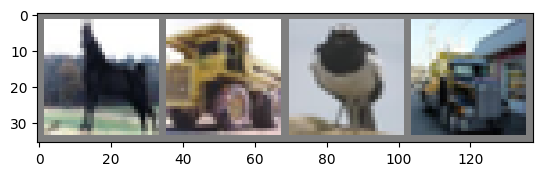

horse truck bird  truck


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 画像を表示するためのヘルパー関数
def imshow(img):
    img = img / 2 + 0.5     # 正規化を元に戻す
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# DataLoader から画像を取得して表示する関数
def show_images(dataloader, num_images):
    dataiter = iter(dataloader)
    images, labels = next(dataiter)  # バッチを一つ取得

    # 画像を表示
    imshow(torchvision.utils.make_grid(images[:num_images]))
    # 正解ラベルを表示
    print(' '.join(f'{classes[labels[j]]:5s}' for j in range(num_images)))

# 使用例：trainloader から 4 枚の画像を表示
show_images(trainloader, 4)


In [ ]:
# 2. CNNモデルを定義する
# Net クラスは、CNNモデルのアーキテクチャを定義します。
# モデルは畳み込み層（nn.Conv2d）、プーリング層（nn.MaxPool2d）、全結合層（nn.Linear）から構成されています。
# forward メソッドは、ネットワークを通じて入力がどのように進むかを定義します

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# インスタンス化。Net クラス（設計図）のオブジェクト（実体）を net とする
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = Net().to(device)

# 3. 損失関数とオプティマイザを定義する
#     損失関数（nn.CrossEntropyLoss）は、モデルの予測と実際のラベル間の差異を測定します。
#    最適化アルゴリズム（optim.SGD）は、モデルのパラメータを調整するために使用されます。

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

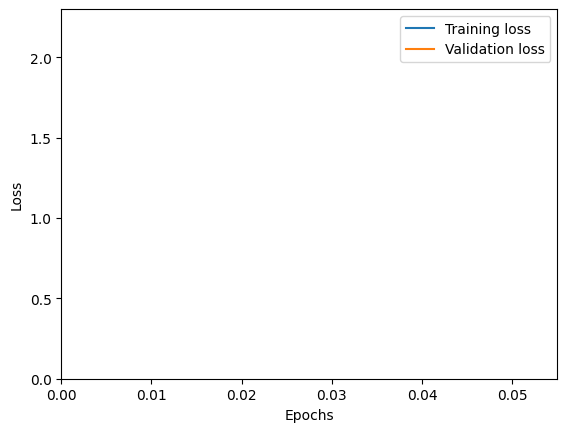

Train loss     :  2.298185393810272
Validation loss:  2.289945065975189


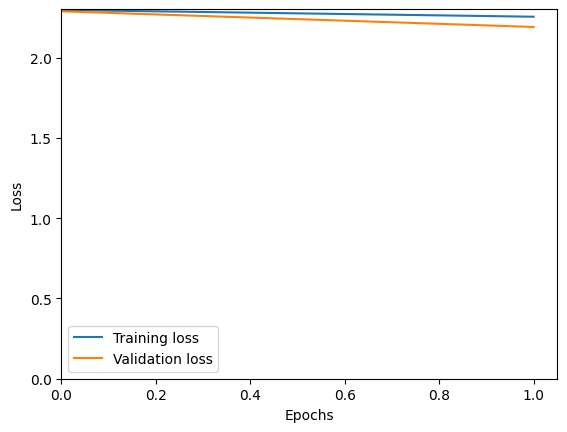

Train loss     :  2.256135215163231
Validation loss:  2.192282464504242


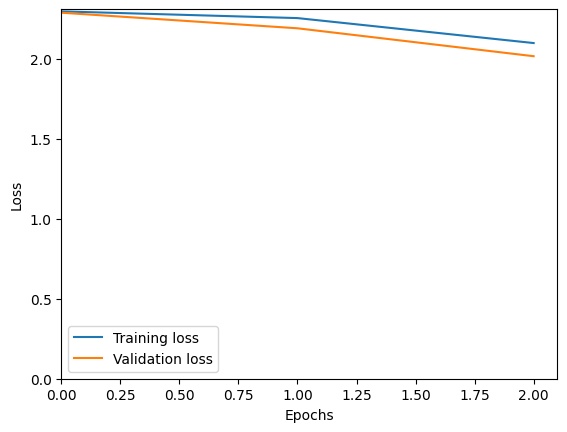

Train loss     :  2.0999378833174704
Validation loss:  2.017627454996109


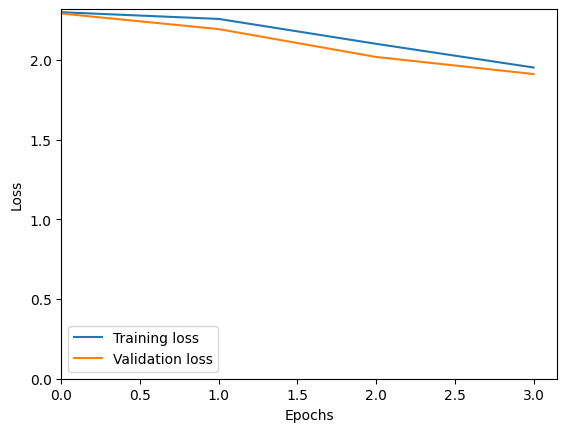

Train loss     :  1.9514722192287446
Validation loss:  1.9103744447231292


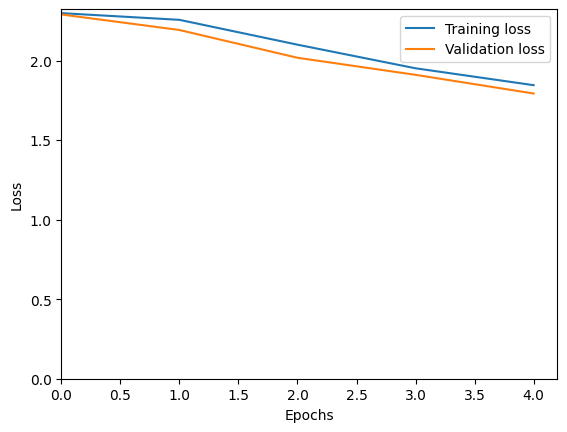

Train loss     :  1.845318510234356
Validation loss:  1.792940595149994


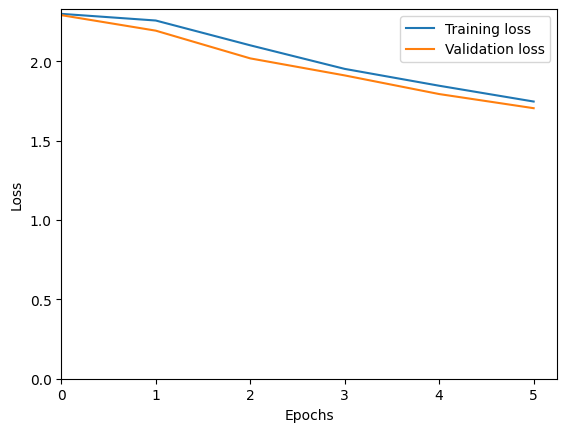

Train loss     :  1.745812156200409
Validation loss:  1.7038964605331421


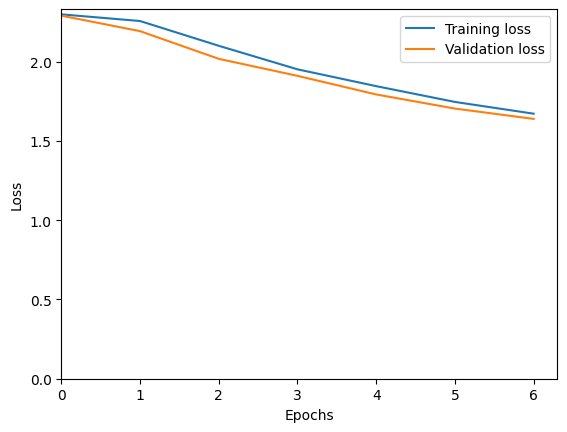

Train loss     :  1.6716326931118966
Validation loss:  1.6388021779060364


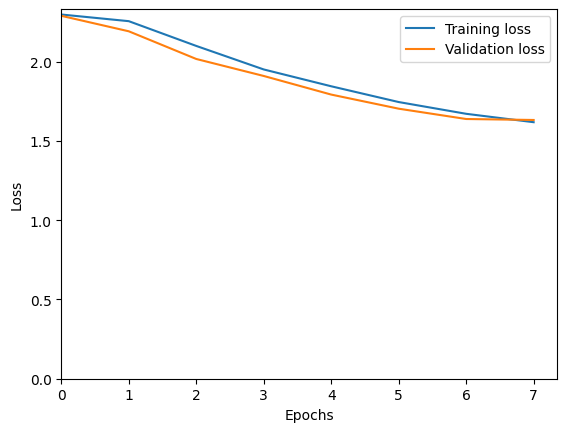

Train loss     :  1.6186081022024155
Validation loss:  1.6326685643196106


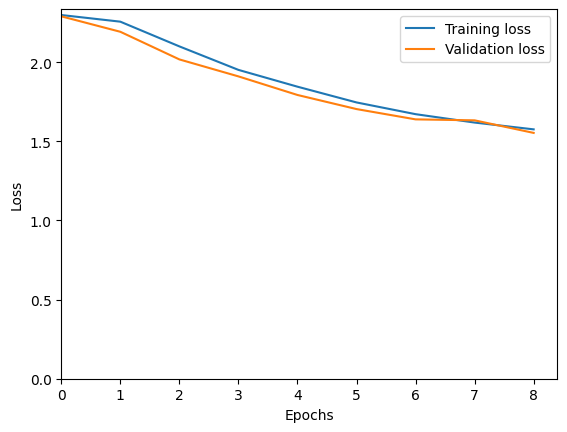

Train loss     :  1.5756963190436364
Validation loss:  1.553279002904892


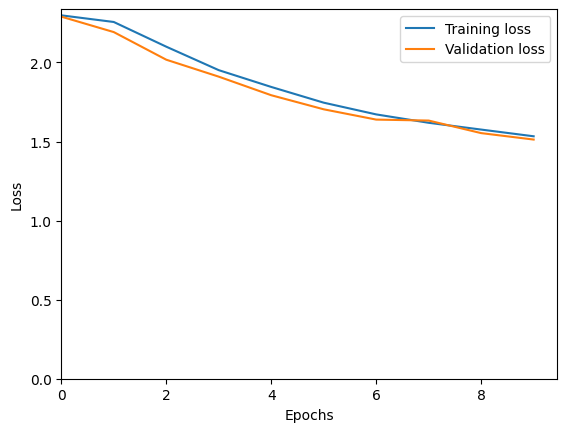

Train loss     :  1.5332699021697045
Validation loss:  1.5124946188926698
Finished Training


In [ ]:
# 4. ネットワークをトレーニングする
#     トレーニングループは、データセットを複数回（エポック）処理します。
#    各イテレーションで、モデルは入力データに対する予測を行い、損失を計算し、勾配を逆伝播させてパラメータを更新します。

# なお、検証用データセットに対する損失が5エポック連続で改善しない場合、学習を終了します。
best_val_loss = float("inf")
patience = 5
trigger_times = 0

train_losses = []
val_losses = []

for epoch in range(10):  # データセットを複数回ループ
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # if i % 2000 == 1999:    # 2000ミニバッチごとに出力
        #    print('[%d, %5d] loss: %.3f' %
        #          (epoch + 1, i + 1, running_loss / 2000))
        #    running_loss = 0.0

    # 検証用データセットに対する損失を計算
    val_loss = 0.0
    net.eval()
    with torch.no_grad():
        for data in validationloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    train_losses.append(running_loss / len(trainloader))
    val_losses.append(val_loss / len(validationloader))

    # 損失の値をグラフとして表示
    plt.clf()
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.legend()
    plt.show()
    print("Train loss     : ", running_loss / len(trainloader))
    print("Validation loss: ", val_loss / len(validationloader))

    # 検証用データセットに対する損失が改善しないエポックが続いたら学習を終了
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

print('Finished Training')

In [ ]:
# 5. ネットワークのテスト
#     テストフェーズでは、訓練されたモデルを使用してテストデータセット上でのパフォーマンスを評価します。
#    最終的な精度（正確に分類された画像の割合）が計算され、出力されます。

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 45 %


Image 0


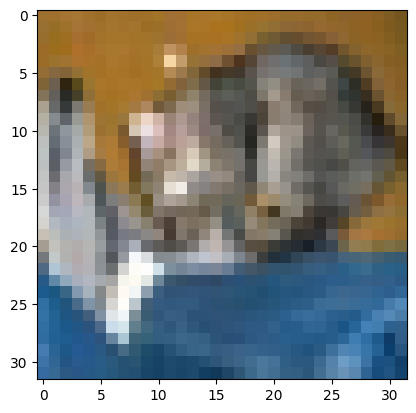

Correct label: cat
Predicted label: cat

Image 1


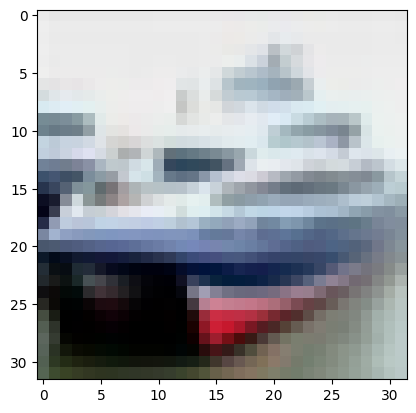

Correct label: ship
Predicted label: ship

Image 2


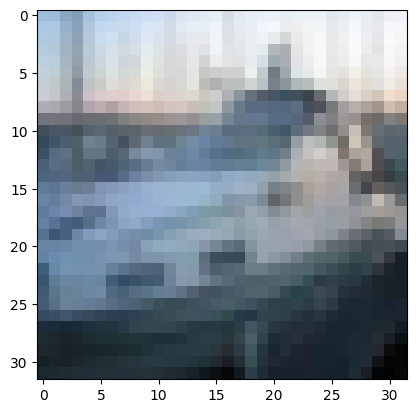

Correct label: ship
Predicted label: ship

Image 3


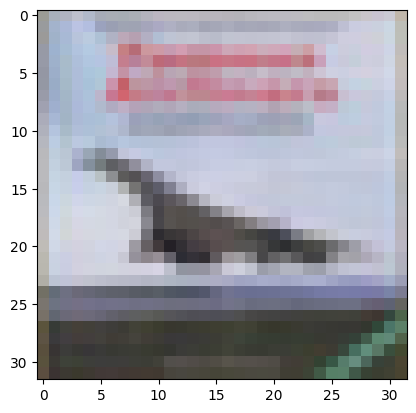

Correct label: plane
Predicted label: ship

Image 4


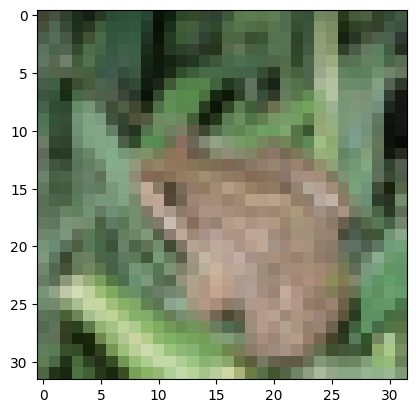

Correct label: frog
Predicted label: frog



In [ ]:
# テストデータの画像を表示し、正解と推定値を表示する関数
def visualize_test_predictions(start_idx, end_idx):
    testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                             shuffle=False, num_workers=2)
    images, labels = zip(*[(data[0], data[1]) for i, data in enumerate(testloader) if start_idx <= i < end_idx])

    # モデルの予測
    predicted_labels = []
    with torch.no_grad():
        for image in images:
            image = image.to(device)
            outputs = net(image)
            _, predicted = torch.max(outputs, 1)
            predicted_labels.append(predicted.item())

    # 画像とラベルを表示
    for i in range(len(images)):
        print(f"Image {start_idx + i}")
        imshow(torchvision.utils.make_grid(images[i]))
        print(f"Correct label: {classes[labels[i]]}")
        print(f"Predicted label: {classes[predicted_labels[i]]}\n")

# 例: インデックス範囲 0 から 5 の画像を表示
visualize_test_predictions(0, 5)
